<a href="https://colab.research.google.com/github/maulishree/Fraudulent-Transactions/blob/main/Feature_Engg_Model_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


**Library Imports**

In [2]:
import pandas as pd # linear algebra
import numpy as np # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import time
import datetime
import json

import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
%matplotlib inline

from tqdm import tqdm_notebook

pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb

#from catboost import CatBoostRegressor

import gc

import warnings
warnings.filterwarnings("ignore")

#import eli5
#import shap
from IPython.display import HTML
import altair as alt
import networkx as nx

!pip install category_encoders
import category_encoders as ce


     |████████████████████████████████| 82 kB 383 kB/s 


In [3]:
path="/content/gdrive/MyDrive/Stat-432_Project/"

**Fetch Data**

In [4]:
train_id1=pd.read_csv(path+"train_identity.csv")
train_tr1=pd.read_csv(path+"train_transaction.csv")


Data: 
In the dataset, we are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

The data is broken into two files identity and transaction, which are joined by TransactionID. We note that not all transactions have corresponding identity information

In [5]:
train_id1.shape, train_id1['TransactionID'].nunique()

((144233, 41), 144233)

In [6]:
train_tr1.shape, train_tr1['TransactionID'].nunique()

((590540, 394), 590540)

Merging transaction and identity table followed by Splitting data into training and testing datset

In [7]:
from sklearn.model_selection import train_test_split

df= pd.merge(train_tr1, train_id1, on='TransactionID', how='left')
xtrain1 , xtest ,ytrain1, ytest = train_test_split(df.loc[:, ~df.columns.isin(['isFraud'])], \
                                                 df['isFraud'], test_size =0.2,shuffle = False,random_state =7)

xtrain = df.loc[:, ~df.columns.isin(['isFraud'])]
ytrain = df['isFraud']


train = xtrain
train['isFraud'] = ytrain
test = xtest.reset_index(drop=True)
ytest = ytest.reset_index(drop=True)
#train_id = train[train_id1.columns.tolist()].drop_duplicates().reset_index(drop=True)
#train_tr = train[train_tr1.columns.tolist()].drop_duplicates().reset_index(drop=True)

In [8]:
df.shape

(590540, 434)

In [9]:
train_id1.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [10]:
train_tr1.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
del xtrain1
del ytrain1

In [12]:
print(train.shape)
print(test.shape)

(590540, 434)
(118108, 433)


In [13]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

**FEATURE ENGINEERING**: Performing transformation, feature extraction (PCA),  feature selection and creation of new features

Setting date: Feature extraction

In [14]:
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

test["Date"] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

test['_Weekdays'] = test['Date'].dt.dayofweek
test['_Hours'] = test['Date'].dt.hour
test['_Days'] = test['Date'].dt.day

In [15]:
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
startdate 

datetime.datetime(2017, 12, 1, 0, 0)

In [16]:
df_train = reduce_mem_usage(train)
df_test = reduce_mem_usage(test)

Mem. usage decreased to 656.67 Mb (66.8% reduction)
Mem. usage decreased to 129.42 Mb (67.1% reduction)


In [17]:
'''plt.figure(figsize=(10,6))
sns.heatmap(df_train.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("visualizing_missing_data")'''

'plt.figure(figsize=(10,6))\nsns.heatmap(df_train.isna().transpose(),\n            cmap="YlGnBu",\n            cbar_kws={\'label\': \'Missing Data\'})\nplt.savefig("visualizing_missing_data")'

In [18]:
del train
del test

In [19]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Performing Feature extraction on id_23, id_30, id_31, id_33, id_34.


In [20]:


df_train["id_23"].sample(50)
df_train["id_23"].value_counts()

IP_PROXY:TRANSPARENT    3489
IP_PROXY:ANONYMOUS      1071
IP_PROXY:HIDDEN          609
Name: id_23, dtype: int64

In [21]:
def id_split(dataframe):

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]

    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe

In [22]:
df_train= id_split(df_train)

In [23]:
df_train.shape

(590540, 445)

Feature Transformation of addr1 and addr2

In [24]:
df_train.loc[df_train.addr1.isin(df_train.addr1.value_counts()[df_train.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
df_train.loc[df_train.addr2.isin(df_train.addr2.value_counts()[df_train.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

In [25]:
df_train.columns[54:393]

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=339)

**V Features**: Feature extraction:
Using PCA to reduce 339 V features to 35 components, and further using kmeans to cluster.

In [26]:
def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)
    principalComponents = pca.fit_transform(df[cols])
    print(sum(pca.explained_variance_ratio_))
    principalDf = pd.DataFrame(principalComponents)
    df.drop(cols, axis=1, inplace=True)
    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)
    df = pd.concat([df, principalDf], axis=1)   
    return df

In [27]:
mas_v = df_train.columns[54:393].tolist()

for col in mas_v:
    df_train[col].fillna(-999, inplace=True)
    df_train[col] = (minmax_scale(df_train[col], feature_range=(0,1)))
    
df_train = PCA_change(df_train, mas_v, prefix='PCA_V_', n_components=35)


0.9999919429776009


Creation of new feature: "clusters_V"

In [28]:
columns = ['PCA_V_0', 'PCA_V_1', 'PCA_V_2', 'PCA_V_3', 'PCA_V_4', 'PCA_V_5', 
           'PCA_V_6', 'PCA_V_7', 'PCA_V_8', 'PCA_V_9', 'PCA_V_10', 'PCA_V_11', 
           'PCA_V_12', 'PCA_V_13', 'PCA_V_14', 'PCA_V_15', 'PCA_V_16', 
           'PCA_V_17', 'PCA_V_18', 'PCA_V_19', 'PCA_V_20', 'PCA_V_21', 
           'PCA_V_22', 'PCA_V_23', 'PCA_V_24', 'PCA_V_25', 'PCA_V_26', 
           'PCA_V_27', 'PCA_V_28', 'PCA_V_29', 'PCA_V_30', 'PCA_V_31', 
           'PCA_V_32', 'PCA_V_33', 'PCA_V_34']

km = KMeans(n_clusters=6)
km = km.fit(df_train[columns])

df_train['clusters_V'] = km.predict(df_train[columns])

gc.collect()

df_train.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud,Date,_Weekdays,_Hours,_Days,OS_id_30,version_id_30,browser_id_31,version_id_31,screen_width,screen_height,had_id,PCA_V_0,PCA_V_1,PCA_V_2,PCA_V_3,PCA_V_4,PCA_V_5,PCA_V_6,PCA_V_7,PCA_V_8,PCA_V_9,PCA_V_10,PCA_V_11,PCA_V_12,PCA_V_13,PCA_V_14,PCA_V_15,PCA_V_16,PCA_V_17,PCA_V_18,PCA_V_19,PCA_V_20,PCA_V_21,PCA_V_22,PCA_V_23,PCA_V_24,PCA_V_25,PCA_V_26,PCA_V_27,PCA_V_28,PCA_V_29,PCA_V_30,PCA_V_31,PCA_V_32,PCA_V_33,PCA_V_34,clusters_V
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315,87,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2017-12-02 00:00:00,5,0,2,NaN,NaN,NaN,NaN,NaN,NaN,1,-1.783416748046875,2.543257951736450,0.905638277530670,-2.416484117507935,0.461850404739380,0.007556845434010,0.144935920834541,0.053625866770744,-0.014396078884602,-0.002437719609588,0.003474890952930,-0.000913008640055,-0.000038967205910,-0.000872122414876,-0.003645502496511,-0.008978273719549,-0.000012312798390,0.000004529958460,-0.000342047394952,-0.000525223033037,0.000245236617047,0.000244994182140,0.000425728765549,-0.001555611612275,-0.002398770535365,-0.001053267507814,-0.000887937087100,0.000257787178271,0.001582173747011,0.000385323393857,0.000297521444736,0.000568741175812,-0.000250854529440,0.000798044377007,0.000806276570074,0
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325,87,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2017-12-02 00:00:01,5,0,2,NaN,NaN,NaN,NaN,NaN,NaN,1,-2.032752275466919,-0.627076208591461,1.317134737968445,1.817787289619446,0.327333927154541,-0.112559564411640,-0.020265899598598,-0.014303545467556,0.034978222101927,-0.011539324186742,0.000435462192399,0.004504004959017,0.002900807419792,0.002481616567820,0.001317125861533,-0.009690730832517,-0.000032660769648,-0.001040523638949,-0.001721129869111,-0.000486805161927,0.000441210373538,0.000517404114362,-0.001740821055137,-0.000864419096615,-0.001558283111081,-0.000657674798276,-0.000909438531380,-0.000124198326375,0.001244324259460,-0.000090353765700,0.000287224742351,0.000871013035066,-0.000017077190932,0.000144705263665,0.000482713017846,5
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330,87,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,F,F,F,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2017-12-02 00:01:09,5,0,2,NaN,NaN,NaN,NaN,NaN,NaN,1,-2.781538486480713,0.060481209307909,-1.154955267906189,-0.049935076385736,-0.141154155135155,0.006674712523818,-0.033297933638096,-0.010951675474644,0.001505078049377,-0.004178633913398,-0.000783267430961,-0.002811269834638,-0.000027215812224,-0.000072865725087,0.001054290216416,-0.010002354159951,-0.000009467972632,-0.000512400467414,-0.000794809428044,-0.000017565667804,0.000285500835162,0.000543884

**`C Features`**: Feature extraction and feature creation
Using PCA to reduce 14 C features to  3 components, and further using kmeans to cluster.

In [29]:
c_feat = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', \
              'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']

for col in c_feat:
    df_train[col] = df_train[col].fillna((df_train[col].min() - 1))
    df_train[col] = (minmax_scale(df_train[col], feature_range=(0,1)))
  
df_train = PCA_change(df_train, c_feat, prefix='PCA_C_', n_components=3)

c_features = ['PCA_C_0', 'PCA_C_1', 'PCA_C_2']

km = KMeans(n_clusters=4)
km = km.fit(df_train[c_features])
df_train['clusters_C'] = km.predict(df_train[c_features])

df_train.head()
df_train.shape

0.984057349651725


(590540, 132)

**M Features**: Imputing NA values to 'None'

In [30]:
m_feat = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

for col in m_feat:
    df_train[col].fillna('None', inplace=True)


**ID**: Applying Transformation and imputation

In [31]:
id_num_cols = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 
               'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11']
    
for col in id_num_cols:
    df_train[col] = (minmax_scale(df_train[col], feature_range=(0,1)))
    df_train[col].fillna(-1, inplace=True)


**D Features** : Feature extraction and feature creation Using PCA to reduce 15 D features to 8 components, and further using kmeans to cluster.

In [32]:
d_features = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9',
              'D10', 'D11', 'D12', 'D13', 'D14', 'D15']

for col in d_features:
    df_train[col] = (minmax_scale(df_train[col], feature_range=(0,1)))
    df_train[col] = df_train[col].fillna(-1)
  
df_train = PCA_change(df_train, d_features, 
                prefix='PCA_D_', n_components=8)

pca_d = ['PCA_D_0', 'PCA_D_1', 'PCA_D_2', 'PCA_D_3',
         'PCA_D_4', 'PCA_D_5', 'PCA_D_6', 'PCA_D_7']

km = KMeans(n_clusters=8)
km = km.fit(df_train[pca_d])
df_train['clusters_D'] = km.predict(df_train[pca_d])

0.9532163617494753


Feature Creation : Summation of all three clusters. 
We can check the results with and without using these new clustering features, to see which gives higher accuracy in the model.

In [33]:
df_train['count_cluster'] = df_train['clusters_C'] + df_train['clusters_V'] + df_train['clusters_D']


In [34]:
print(pd.concat([df_train[df_train['isFraud'] == 1]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(), 
                 df_train[df_train['isFraud'] == 0]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))

  Fraud                      No Fraud                      
  index       TransactionAmt    index        TransactionAmt
0  0.01    6.739453125000001     0.01     9.511875000000003
1  0.10   18.937500000000000     0.10    26.312500000000000
2  0.25   35.031250000000000     0.25    43.968750000000000
3  0.50   75.000000000000000     0.50    68.500000000000000
4  0.75  161.000000000000000     0.75   120.000000000000000
5  0.90  335.000000000000000     0.90   267.100000000005821
6  0.99  994.000000000000000     0.99  1104.000000000000000


Feature Transformation : We can see that Transaction amount has a large distribution of values, so it might benefit from being converted to log scale.

In [35]:
df_train['TransactionAmt'] = np.log(df_train['TransactionAmt'])


Feature Transformation : 

Since the number of categories in "id_31" is  high, we will apply target encoding. 
In target encoding, we used the mean of the ‘TransactionAmt’ variable for each category and replaced the category variable with the mean value. The main drawback of this type of encoding is that the output is dependent on the distribution of the target, which may lead to overfitting. Hence, we relied on ‘TransactionAm  instead of using the ‘isFraud’ variable directly.

In [36]:
#!pip3 install --upgrade category_encoders

df_train_id = df_train[['id_31', 'TransactionAmt']].copy()
encoder=ce.TargetEncoder(cols='id_31') 
df_train['id_31']= encoder.fit_transform(df_train_id['id_31'],df_train_id['TransactionAmt'])
df_train['id_31']

encoder=ce.TargetEncoder(cols='id_31') 


Creation of features : 

UID (unique client ID) is created to perform aggregation of features so that model doesn't depend on single/indentity feature rather it depends on aggregated features to avoid overfitting. This allows us to validate how models perform on seen versus unseen clients.

First we need a UID variable to identify clients (credit cards). Second, we need to create aggregated group features.

In [37]:
def addNewFeatures(data): 
    data['uid'] = data['card1'].astype(str)+'_'+data['card2'].astype(str)

    data['uid2'] = data['uid'].astype(str)+'_'+data['card3'].astype(str)+'_'+data['card5'].astype(str)

    data['uid3'] = data['uid2'].astype(str)+'_'+data['addr1'].astype(str)+'_'+data['addr2'].astype(str)
    
    return data

df_train = addNewFeatures(df_train)


We cannot add UID as a new column because most of the clients in test dataset are not in the training dataset. Instead we must create aggregated group features to prevent overfitting.

In [38]:
i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = df_train[[col, 'TransactionAmt']].copy()

        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   

        df_train[new_col_name] = df_train[col].map(temp_df)


In [39]:
df_train = df_train.drop(['uid','uid2','uid3'], 1)


Feature Extraction:

Handling email domains : Many companies have different domains for different countries. Assigning same names for each of the companies to ease analysis. 

In [40]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', \
          'bellsouth.net': 'other', \
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    df_train[c + '_bin'] = df_train[c].map(emails)
    
    df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1])
    
    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')


Feature Extraction:

In the device info, many devices are abbreviated but they belong to the same category. Hence, creating a column device name to categorise them together.

In [41]:
def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'
    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    
    return df

df_train=setDevice(df_train)



Feature Selection:

Using correlation to drop highly correlated features.

In [42]:
threshold = 0.98
    
# Absolute value correlation matrix
corr_matrix = df_train[df_train['isFraud'].notnull()].corr().abs()

# Getting the upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

df_train = df_train.drop(columns = to_drop)


In [43]:
to_drop

['TransactionDT',
 'id_04',
 'id_06',
 'id_08',
 'id_10',
 'id_11',
 'uid_TransactionAmt_mean',
 'uid_TransactionAmt_std',
 'uid2_TransactionAmt_mean',
 'uid2_TransactionAmt_std']

Dropping Date and TransactionID from the data as both the columns are unique. One is time-related information which is included in D features and the other is a unique id. Adding this to the model doesn't make much sense.


In [44]:
df_train = df_train.drop(['Date', 'TransactionID'], 1)

Imputating missing values with -999:
LIGHTGBM will ignore missing values during a split, then allocate them to whichever side reduces the loss the most. When NANs are present in the dataset, if we apply LGBM, it may cause the data to become overfit since all the NANs will be assigned to either left or right child of the node. Therefore, if we convert NAN to a value lower than all NAN values (-999), then LGBM will no longer overprocess NANs, and will give it equal attention as other numbers.


In [45]:
df_train.fillna(-999, inplace=True)
df_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_05,id_07,id_09,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud,_Weekdays,_Hours,_Days,OS_id_30,version_id_30,browser_id_31,version_id_31,screen_width,screen_height,had_id,PCA_V_0,PCA_V_1,PCA_V_2,PCA_V_3,PCA_V_4,PCA_V_5,PCA_V_6,PCA_V_7,PCA_V_8,PCA_V_9,PCA_V_10,PCA_V_11,PCA_V_12,PCA_V_13,PCA_V_14,PCA_V_15,PCA_V_16,PCA_V_17,PCA_V_18,PCA_V_19,PCA_V_20,PCA_V_21,PCA_V_22,PCA_V_23,PCA_V_24,PCA_V_25,PCA_V_26,PCA_V_27,PCA_V_28,PCA_V_29,PCA_V_30,PCA_V_31,PCA_V_32,PCA_V_33,PCA_V_34,clusters_V,PCA_C_0,PCA_C_1,PCA_C_2,clusters_C,PCA_D_0,PCA_D_1,PCA_D_2,PCA_D_3,PCA_D_4,PCA_D_5,PCA_D_6,PCA_D_7,clusters_D,count_cluster,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid3_TransactionAmt_mean,uid3_TransactionAmt_std,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix,device_name
0,4.226562500,W,13926,-999.0,150.0,discover,142.0,credit,315,87,19.0,-999.0,-999,-999,T,T,T,M2,F,T,None,None,None,-1.0,-1.0000000000000,-1.0,-1.0,-1.0,-1.0,-999,-999.0,-999.0,-999,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999.0,-999,-999,-999,-999,-999.0,-999.0,-999,-999,-999,-999,-999,-999,-999,unknown_device,0,5,0,2,-999,-999,-999,-999,-999,-999,1,-1.783416748046875,2.543257951736450,0.905638277530670,-2.416484117507935,0.461850404739380,0.007556845434010,0.144935920834541,0.053625866770744,-0.014396078884602,-0.002437719609588,0.003474890952930,-0.000913008640055,-0.000038967205910,-0.000872122414876,-0.003645502496511,-0.008978273719549,-0.000012312798390,0.000004529958460,-0.000342047394952,-0.000525223033037,0.000245236617047,0.000244994182140,0.000425728765549,-0.001555611612275,-0.002398770535365,-0.001053267507814,-0.000887937087100,0.000257787178271,0.001582173747011,0.000385323393857,0.000297521444736,0.000568741175812,-0.000250854529440,0.000798044377007,0.000806276570074,0,-0.026583916153735,0.002529985980877,0.000641152283252,0,0.268974860194338,-0.865544199292017,0.092377406329049,0.078574580861236,-0.633499158152557,-0.200194464894591,-0.714500075133772,-0.266284788106663,0,0,5.33593750,1.053342788855768,-999.00000000,-999.000000000000000,4.48046875,0.901226420106827,4.56640625,1.027624000977192,4.992187500,1.085519394555911,-999,nan,-999,nan,unknown_device
1,3.367187500,W,2755,404.0,150.0,mastercard,102.0,credit,325,87,-999.0,-999.0,gmail.com,-999,None,None,None,M0,T,T,None,None,None,-1.0,-1.0000000000000,-1.0,-1.0,-1.0,-1.0,-999,-999.0,-999.0,-999,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999.0,-999,-999,-999,-999,-999.0,-999.0,-999,-999,-999,-999,-999,-999,-999,unknown_device,0,5,0,2,-999,-999,-999,-999,-999,-999,1,-2.032752275466919,-0.627076208591461,1.317134737968445,1.817787289619446,0.327333927154541,-0.112559564411640,-0.020265899598598,-0.014303545467556,0.034978222101927,-0.011539324186742,0.000435462192399,0.004504004959017,0.002900807419792,0.002481616567820,0.001317125861533,-0.009690730832517,-0.000032660769648,-0.001040523638949,-0.001721129869111,-0.000486805161927,0.000441210373538,0.000517404114362,-0.001740821055137,-0.000864419096615,-0.001558283111081,-0.000657674798276,-0.000909438531380,-0.000124198326375,0.001244324259460,-0.000090353765700,0.000287224742351,0.000871013035066,-0.000017077190932,0.000144705263665,0.000482713017846,5,-0.029562067793443,0.004074075732377,-0.002568287817402,0,0.692972936602696,-0.356808122180985,-0.652409804656863,-0.520633265711691,0.200641002605516,0.530936262642545,0.107025296858436,-0.039978069899318,1,6,4.83203125,0.977663272511035,4.84375000,1.030404977672542,4.48046

In [46]:
xtrain, ytrain = df_train.loc[:, ~df_train.columns.isin(['isFraud'])], df_train['isFraud']

Feature Transformation :
Applying Label Encoder on categorical variables


In [47]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
for column_name in xtrain.columns:
    if xtrain[column_name].dtype == object:
        xtrain[column_name] = le.fit_transform(xtrain[column_name].astype(str))
    else:
        pass


In [48]:
scaler = StandardScaler() #MinMaxScaler StandardScaler RobustScaler

cols = list(xtrain.columns)
xtrain[cols] = scaler.fit_transform(xtrain[cols])


**MODEL FITTING**

Time Series Split is used for validation in all the models and AUC and Accuracy scores are calculated.

Models used:
*   Logistic Regression
*   Decision Tree
*   Random Forest
*   Light Gradient Boosting Machine


**LOGISTIC REGRESSION**

Train: [    0     1     2 ... 98422 98423 98424] Validation: [ 98425  98426  98427 ... 196845 196846 196847]
0.802631718495709
Train: [     0      1      2 ... 196845 196846 196847] Validation: [196848 196849 196850 ... 295268 295269 295270]
0.8027154033169808
Train: [     0      1      2 ... 295268 295269 295270] Validation: [295271 295272 295273 ... 393691 393692 393693]
0.8125058709094591
Train: [     0      1      2 ... 393691 393692 393693] Validation: [393694 393695 393696 ... 492114 492115 492116]
0.8216426082588831
Train: [     0      1      2 ... 492114 492115 492116] Validation: [492117 492118 492119 ... 590537 590538 590539]
0.8077836757826179


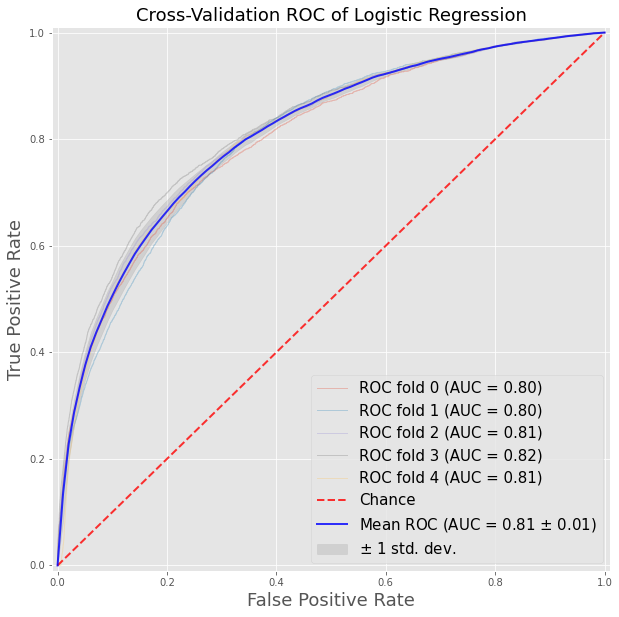

0.80945585535273
0.7788870487589283


In [49]:

n_fold= 5
X = xtrain.copy()
y = ytrain.copy()
skf = TimeSeriesSplit(n_splits=n_fold)

scores= []
tpr_folds = []
mean_fpr = np.linspace(0, 1, 100)
accuracy = []
# X is the feature set and y is the target
plt.figure(figsize=(10,10))
for i, (train_index, val_index) in enumerate(skf.split(X,y)): 
    print("Train:", train_index, "Validation:", val_index) 
    X_train, X_valid = X.iloc[train_index], X.iloc[val_index] 
    y_train, y_valid = y.iloc[train_index], y.iloc[val_index]
    
    reg = SGDClassifier(penalty="l2", loss="log", alpha = 0.01, class_weight= "balanced").fit(X_train, y_train)
            
    y_pred_valid_prob = reg.predict_proba(X_valid)[:, 1]
    y_pred_valid = reg.predict(X_valid)

    #print(metrics.roc_auc_score(y_valid, y_pred_valid_prob))
    #scores.append(metrics.roc_auc_score(y_valid, y_pred_valid_prob))
    fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_valid_prob, pos_label=1)
    tpr_folds.append(np.interp(mean_fpr, fpr, tpr))

    auc = metrics.auc(fpr, tpr)
    accuracy.append(accuracy_score(y_valid, y_pred_valid))
    print(auc)
    scores.append(auc)

    plt.style.use('ggplot')
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tpr_folds, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(scores)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tpr_folds, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Logistic Regression',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.style.use('ggplot')
plt.show()

print(np.mean(scores))
print(np.mean(accuracy))

**DECISION TREE MODEL FITTING**

Train: [    0     1     2 ... 98422 98423 98424] Validation: [ 98425  98426  98427 ... 196845 196846 196847]
0.7564740692608747
Train: [     0      1      2 ... 196845 196846 196847] Validation: [196848 196849 196850 ... 295268 295269 295270]
0.7761647430542516
Train: [     0      1      2 ... 295268 295269 295270] Validation: [295271 295272 295273 ... 393691 393692 393693]
0.7908497715504954
Train: [     0      1      2 ... 393691 393692 393693] Validation: [393694 393695 393696 ... 492114 492115 492116]
0.8226435186754644
Train: [     0      1      2 ... 492114 492115 492116] Validation: [492117 492118 492119 ... 590537 590538 590539]
0.8052888749391497


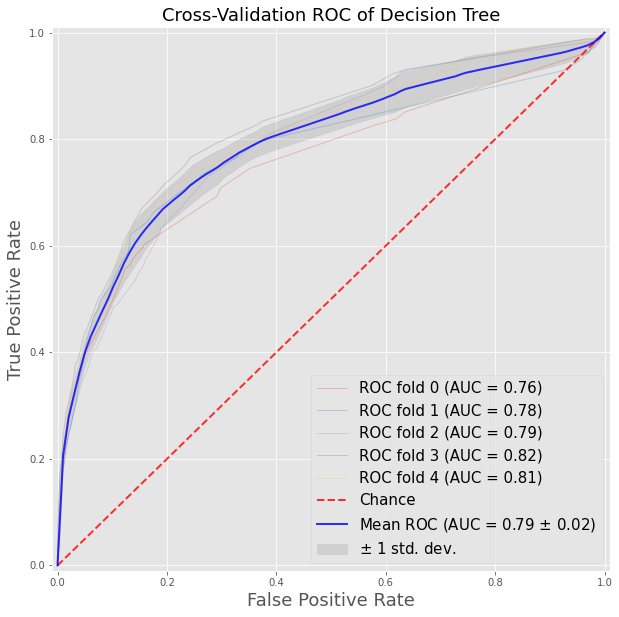

0.7902841954960472
0.8255001371630615


In [50]:
from sklearn.tree import DecisionTreeClassifier
n_fold= 5
X = xtrain.copy()
y = ytrain.copy()
skf = TimeSeriesSplit(n_splits=n_fold)

scores= []
tpr_folds = []
mean_fpr = np.linspace(0, 1, 100)
feature_importance = pd.DataFrame()
columns = X.columns.tolist()
accuracy = []
plt.figure(figsize=(10,10))
# X is the feature set and y is the target
for i, (train_index, val_index) in enumerate(skf.split(X,y)): 
    print("Train:", train_index, "Validation:", val_index) 
    X_train, X_valid = X.iloc[train_index], X.iloc[val_index] 
    y_train, y_valid = y.iloc[train_index], y.iloc[val_index]
    
    dtree = DecisionTreeClassifier(class_weight='balanced', \
                                 max_features = 'sqrt', max_depth = 7, random_state = 42) ## Use all CPUs available

    
    dtree.fit(X_train, y_train)
            
    y_pred_valid_prob = dtree.predict_proba(X_valid)[:, 1]
    y_pred_valid = dtree.predict(X_valid)

    #print(metrics.roc_auc_score(y_valid, y_pred_valid_prob))
    #scores.append(metrics.roc_auc_score(y_valid, y_pred_valid_prob))
    fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_valid_prob, pos_label=1)
    tpr_folds.append(np.interp(mean_fpr, fpr, tpr))

    auc = metrics.auc(fpr, tpr)
    accuracy.append(accuracy_score(y_valid, y_pred_valid))
    print(auc)
    scores.append(auc)

    fold_importance = pd.DataFrame()
    fold_importance["feature"] = columns
    fold_importance["importance"] = dtree.feature_importances_
    fold_importance["fold"] = i + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    plt.style.use('ggplot')
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tpr_folds, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(scores)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tpr_folds, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Decision Tree',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.style.use('ggplot')
plt.show()

print(np.mean(scores))
print(np.mean(accuracy))

**RAMDOM FOREST MODEL FITTING**

Train: [    0     1     2 ... 98422 98423 98424] Validation: [ 98425  98426  98427 ... 196845 196846 196847]
0.8593063637489522
0.8593063637489522
Train: [     0      1      2 ... 196845 196846 196847] Validation: [196848 196849 196850 ... 295268 295269 295270]
0.8658862302265431
0.8658862302265431
Train: [     0      1      2 ... 295268 295269 295270] Validation: [295271 295272 295273 ... 393691 393692 393693]
0.8634144716288015
0.8634144716288015
Train: [     0      1      2 ... 393691 393692 393693] Validation: [393694 393695 393696 ... 492114 492115 492116]
0.8888569950894297
0.8888569950894297
Train: [     0      1      2 ... 492114 492115 492116] Validation: [492117 492118 492119 ... 590537 590538 590539]
0.88903567107652
0.88903567107652


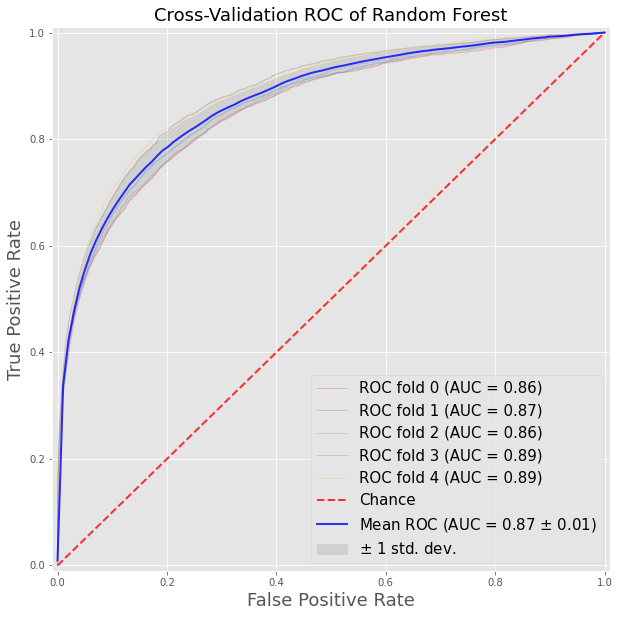

0.8732999463540493
0.9594871117523344


In [51]:

n_fold= 5
X = xtrain.copy()
y = ytrain.copy()
skf = TimeSeriesSplit(n_splits=n_fold)

scores= []
tpr_folds = []
mean_fpr = np.linspace(0, 1, 100)
feature_importance = pd.DataFrame()
columns = X.columns.tolist()
accuracy = []
plt.figure(figsize=(10,10))
# X is the feature set and y is the target
for i, (train_index, val_index) in enumerate(skf.split(X,y)): 
    print("Train:", train_index, "Validation:", val_index) 
    X_train, X_valid = X.iloc[train_index], X.iloc[val_index] 
    y_train, y_valid = y.iloc[train_index], y.iloc[val_index]
    
    rforest = RandomForestClassifier(n_estimators = 100, class_weight='balanced', min_samples_split = 12, \
                                 max_features = 'sqrt', max_depth =15, random_state = 42) ## Use all CPUs available

    
    rforest.fit(X_train, y_train)
            
    y_pred_valid_prob = rforest.predict_proba(X_valid)[:, 1]
    y_pred_valid = rforest.predict(X_valid)

    print(metrics.roc_auc_score(y_valid, y_pred_valid_prob))
    fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_valid_prob, pos_label=1)
    tpr_folds.append(np.interp(mean_fpr, fpr, tpr))

    auc = metrics.auc(fpr, tpr)
    accuracy.append(accuracy_score(y_valid, y_pred_valid))
    print(auc)
    scores.append(auc)

    fold_importance = pd.DataFrame()
    fold_importance["feature"] = columns
    fold_importance["importance"] = rforest.feature_importances_
    fold_importance["fold"] = i + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    plt.style.use('ggplot')
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tpr_folds, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(scores)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tpr_folds, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Random Forest',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

print(np.mean(scores))
print(np.mean(accuracy))

Feature Importance from random forest model

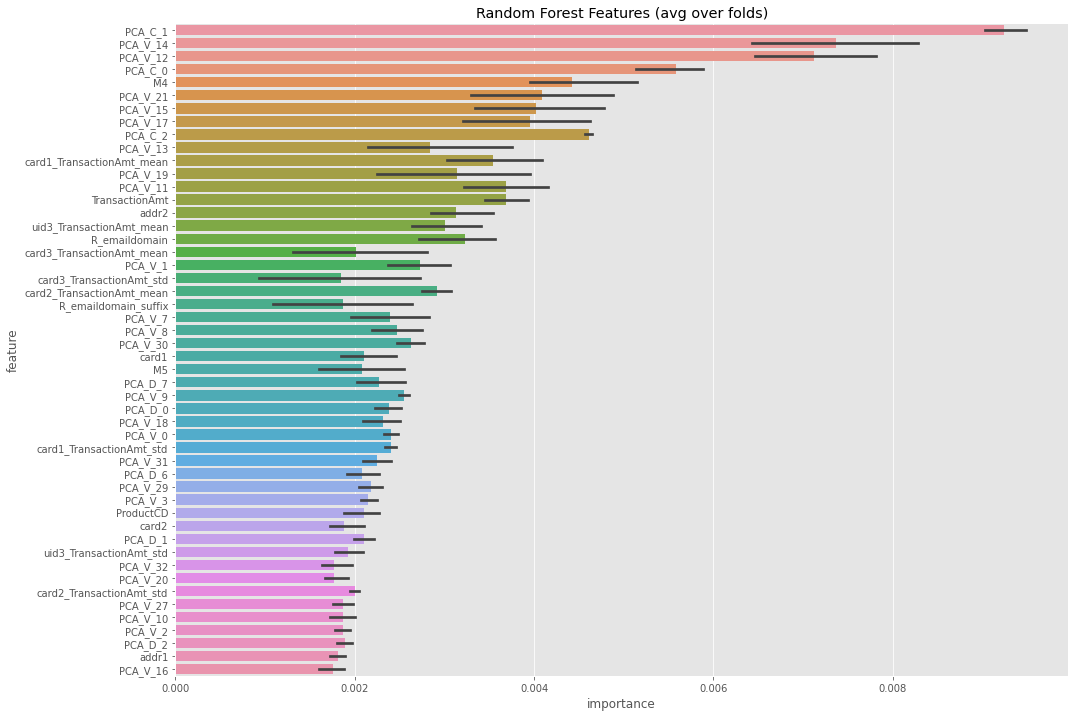

In [52]:
feature_importance["importance"] /= n_fold
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('Random Forest Features (avg over folds)');
plt.style.use('ggplot')

**LGBM** **MODEL**

In [57]:
def eval_auc(y_true, y_pred):

  #return 'auc', fast_auc(y_true, y_pred), True
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
  return 'auc', metrics.auc(fpr, tpr), True

Train: [    0     1     2 ... 98422 98423 98424] Validation: [ 98425  98426  98427 ... 196845 196846 196847]
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.997339	training's auc: 0.997339	valid_1's auc: 0.881812	valid_1's auc: 0.881812
0.8818115115383183
Train: [     0      1      2 ... 196845 196846 196847] Validation: [196848 196849 196850 ... 295268 295269 295270]
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.986328	training's auc: 0.986328	valid_1's auc: 0.900803	valid_1's auc: 0.900803
0.9008030957464457
Train: [     0      1      2 ... 295268 295269 295270] Validation: [295271 295272 295273 ... 393691 393692 393693]
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.973939	training's auc: 0.973939	valid_1's auc: 0.887588	va

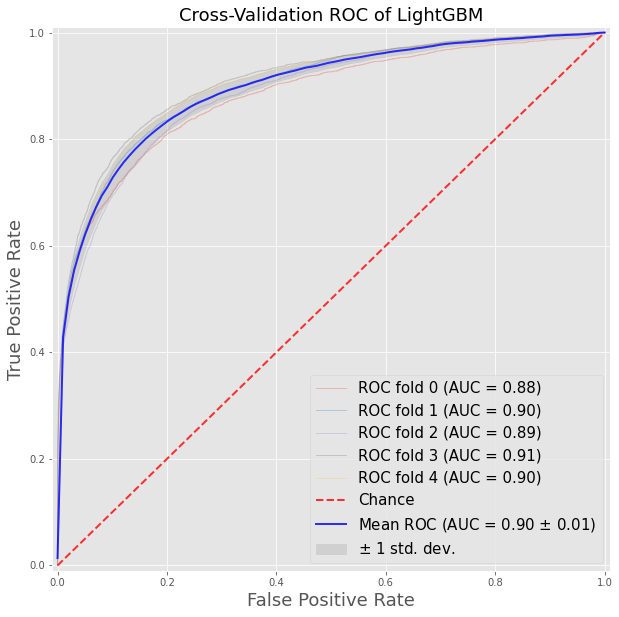

0.89666010471169
0.9711510520914827


In [58]:
n_fold= 5
X = xtrain.copy()
y = ytrain.copy()
skf = TimeSeriesSplit(n_splits=n_fold)

columns = X.columns.tolist()
metrics_dict = {'auc': {'lgb_metric_name': eval_auc}}
scores= []
tpr_folds = []
mean_fpr = np.linspace(0, 1, 100)
accuracy = []

feature_importance = pd.DataFrame()
# X is the feature set and y is the target
plt.figure(figsize=(10,10))
for i, (train_index, val_index) in enumerate(skf.split(X,y)): 
    print("Train:", train_index, "Validation:", val_index) 
    X_train, X_valid = X.iloc[train_index], X.iloc[val_index] 
    y_train, y_valid = y.iloc[train_index], y.iloc[val_index]

    model =lgb.LGBMClassifier( num_leaves= 250, min_child_samples= 79, objective= 'binary',max_depth= 13,
          learning_rate= 0.03, \
          boosting_type= "gbdt", \
          subsample_freq= 3, \
          subsample= 0.9, \
          bagging_seed= 11, \
          metric= 'auc', \
          verbosity= -1, \
          reg_alpha= 0.3, \
          reg_lambda= 0.3, \
          colsample_bytree= 0.9, n_estimators=100, n_jobs=-1, randome_state=42)
   # model.fit(X_train , y_train)

    model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict['auc']['lgb_metric_name'], \
                    verbose=500, early_stopping_rounds=200)
            
    y_pred_valid_prob = model.predict_proba(X_valid)[:, 1]
    y_pred_valid = model.predict(X_valid)
    #y_pred = model.predict_proba(xtest, num_iteration=model.best_iteration_)[:, 1]
            
    #y_pred = model.predict(X_valid)

    fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_valid_prob, pos_label=1)
    tpr_folds.append(np.interp(mean_fpr, fpr, tpr))

    auc = metrics.auc(fpr, tpr)
    print(auc)
    scores.append(auc)
    accuracy.append(accuracy_score(y_valid, y_pred_valid))
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = i + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    plt.style.use('ggplot')
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tpr_folds, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(scores)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tpr_folds, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of LightGBM',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.style.use('ggplot')
plt.show()


print(np.mean(scores))
print(np.mean(accuracy))



Feature Importance from LightGBM model

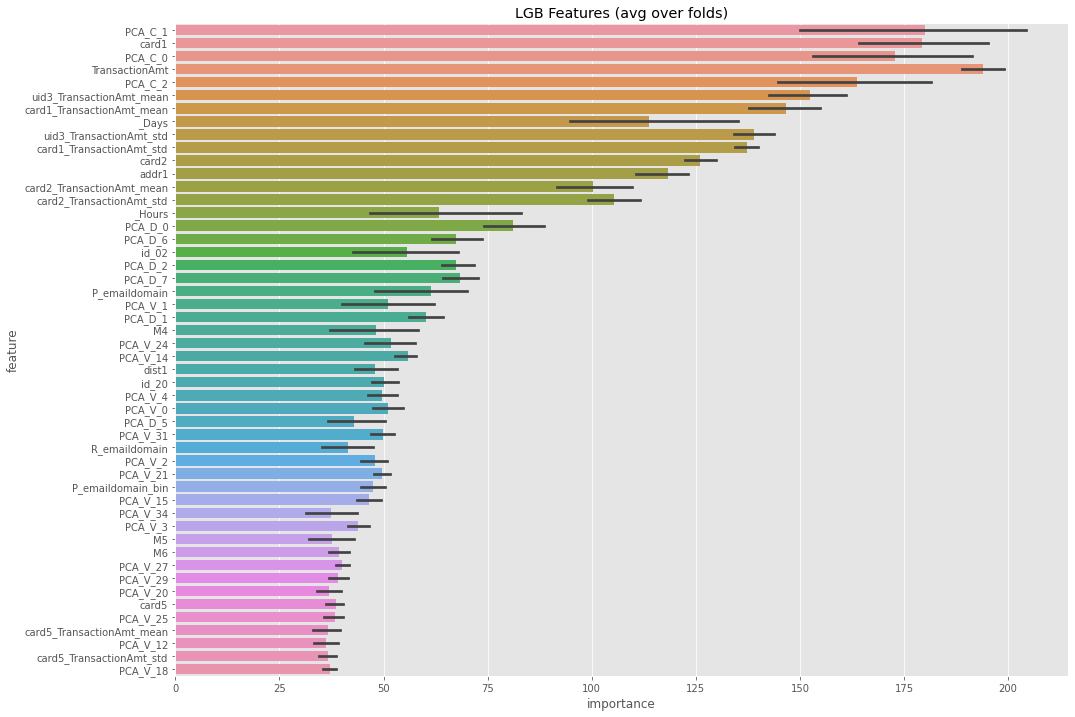

In [59]:

feature_importance["importance"] /= n_fold
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');
plt.style.use('ggplot')


LightGBM model with Top 50 Important Features

Train: [    0     1     2 ... 98422 98423 98424] Validation: [ 98425  98426  98427 ... 196845 196846 196847]
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.996644	training's auc: 0.996644	valid_1's auc: 0.883678	valid_1's auc: 0.883678
0.8836775537893646
Train: [     0      1      2 ... 196845 196846 196847] Validation: [196848 196849 196850 ... 295268 295269 295270]
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.984099	training's auc: 0.984099	valid_1's auc: 0.895796	valid_1's auc: 0.895796
0.8957964466750165
Train: [     0      1      2 ... 295268 295269 295270] Validation: [295271 295272 295273 ... 393691 393692 393693]
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.971783	training's auc: 0.971783	valid_1's auc: 0.885339	va

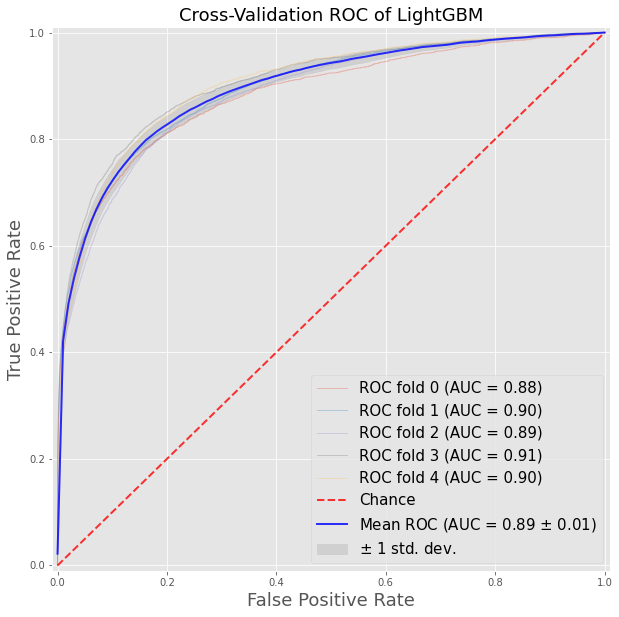

0.8948530374259359
0.9710067768712598


In [60]:
n_fold= 5
X = xtrain[cols]
y = ytrain.copy()
skf = TimeSeriesSplit(n_splits=n_fold)

columns = X.columns.tolist()
metrics_dict = {'auc': {'lgb_metric_name': eval_auc}}
scores= []
tpr_folds = []
mean_fpr = np.linspace(0, 1, 100)
accuracy = []
feature_importance = pd.DataFrame()
# X is the feature set and y is the target
plt.figure(figsize=(10,10))
for i, (train_index, val_index) in enumerate(skf.split(X,y)): 
    print("Train:", train_index, "Validation:", val_index) 
    X_train, X_valid = X.iloc[train_index], X.iloc[val_index] 
    y_train, y_valid = y.iloc[train_index], y.iloc[val_index]

    model =lgb.LGBMClassifier( num_leaves= 250, min_child_samples= 79, objective= 'binary',max_depth= 13,
          learning_rate= 0.03, \
          boosting_type= "gbdt", \
          subsample_freq= 3, \
          subsample= 0.9, \
          bagging_seed= 11, \
          metric= 'auc', \
          verbosity= -1, \
          reg_alpha= 0.3, \
          reg_lambda= 0.3, \
          colsample_bytree= 0.9, n_estimators=100, n_jobs=-1, random_state=42)
   # model.fit(X_train , y_train)

    model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict['auc']['lgb_metric_name'], \
                    verbose=500, early_stopping_rounds=200)
            
    y_pred_valid_prob = model.predict_proba(X_valid)[:, 1]
    y_pred_valid = model.predict(X_valid)
    #y_pred = model.predict_proba(xtest, num_iteration=model.best_iteration_)[:, 1]
            
    #y_pred = model.predict(X_valid)

    fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_valid_prob, pos_label=1)
    tpr_folds.append(np.interp(mean_fpr, fpr, tpr))

    auc = metrics.auc(fpr, tpr)
    print(auc)
    scores.append(auc)
    accuracy.append(accuracy_score(y_valid, y_pred_valid))
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = i + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    

    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tpr_folds, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(scores)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tpr_folds, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of LightGBM',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.style.use('ggplot')
plt.show()


print(np.mean(scores))
print(np.mean(accuracy))
